# Meet the meat - Data Analysis

## Abstract

With increasingly dire climate change forecasts, concerned individuals are asking how they can minimize their carbon footprint. Recent research suggests that reducing one's consumption of meat, in particular beef, is one of the highest impact actions an individual can take. To examine this topic, we will explore the popularity and prevalence of meat in recipes. Specifically, we plan to extract the ingredients from a recipe database and calculate the carbon footprint of recipes

Finally, we hope to directly relate this data to the issue of climate change by estimating a rating reflecting the carbon footprint of meat in recipes and the environmental impact of consumers' diets.

### Imports and libraries

In [22]:
# Import libraries
import re
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#from bs4 import BeautifulSoup
#import os, os.path as osp

import nltk  #to install: activate ada,   conda install -c anaconda nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
#nltk.download('stopwords')

from ast import literal_eval
import string

import seaborn as sns
sns.set(style="whitegrid")

In [23]:
# Define the Fontsize parameters for the plots:
FontSize=14
plt.rcParams['axes.labelsize']=FontSize
plt.rcParams['xtick.labelsize']=FontSize
plt.rcParams['ytick.labelsize']=FontSize
plt.rcParams['legend.fontsize']=FontSize

## Data loading and cleaning
In the Data Extraction part (notebook for MS2), we extract all the information we need from the HTML files dataset, and save it as a CSV file for further analysis. In this second part, we load the data from the CSV file, do some extra cleaning and processing before drawing conclusions from our research.

For the statistical analysis of the data we drop all recipes for which we were not able to properly retrieve the amount of meat ingredients in order to not create artificial spikes in the distributions. In a later time however we assign the median amount to every type of meat. Although we did most of the data cleaning in the previous notebook, we still need to clean out titles from the CSV file, annd remove outliers or other discrepancies that arose when analysing the data from our csv file.

In [24]:
#Import CSV
DATA_FOLDER='data/data_full'
df=pd.read_csv(DATA_FOLDER+'/recipes_data.csv')

In order to compare carbon footprints of recipes, we normalise the recipes per serving.

In [25]:
def normalize_servings(c_f, servs):
    #input is ingredient quantity in kg
    #interpret servings as a total quantity using the check_quantity function
    tot_servs = servs.str.extract(r'(\d+)')#find value
    tot_servs=tot_servs.fillna(value='2') #replace missing values with 2
    tot_servs=tot_servs.astype(int) #convert to int
    c_f_norm=c_f/tot_servs[0]
    return c_f_norm

In [26]:
#Remove the '\n', '\r' and '\t' produced by the CSV/dataframe conversion
df_clean = df.copy()
df_clean['Recipe Title'] = df_clean['Recipe Title'].str.replace('\n', '').str.replace('\t', '').str.replace('\r', '')
df_clean['Servings'] = df_clean['Servings'].str.replace('\n', '').str.replace('\t', '').str.replace('\r', '')

#normalise carbon footprint per servings
df_clean['Carbon footprint'] = normalize_servings(df_clean['Carbon footprint'],df_clean['Servings'])
df_clean = df_clean.rename(columns = {'Carbon footprint':'Carbon footprint- Normalised'}, inplace = False)

# drop all recipes for which we have NaN or inf values in Carbon footprint or Rating
df_clean=df_clean.replace([np.inf,-np.inf], np.nan).dropna(subset=["Carbon footprint- Normalised", "Rating"], how="any")

# drop all recipes with an extravagant carbon footprint
#df_clean = df_clean[df_clean['Carbon footprint- Normalised'] < 70]

#Create seperate dataframes for recipes with and without ingredient in the high carbon footprint list:
df_meat = df_clean[df_clean['Has meat']]
df_meat = df_meat[df_meat['Carbon footprint- Normalised'] > 0.001]
df_no_meat = df_clean[df_clean['Has meat']==False]

df_clean.head()

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint- Normalised,Rating,Website,Servings
0,French Dip Sandwiches Recipe : Rachael Ray : R...,True,"['beef', 'beef', 'beef']","[0, 0.6802721088435374, 0]",4.591837,5.0,food network,4 servings
3,Baked Buffalo Wings Recipe - Allrecipes.com,True,['chicken'],[0],0.000000,4.4,allrecipes,20 chicken wings
5,Fast Rice Pudding Recipe - Allrecipes.com,False,[],0,0.000000,4.1,allrecipes,3 servings
7,Chicken Breast Cutlets with Artichokes and Cap...,True,"['chicken', 'chicken']","[0.9070294784580498, 0]",1.043084,4.4,allrecipes,6 servings
8,Best Ever Popcorn Balls Recipe - Allrecipes.com,False,[],0,0.000000,4.4,allrecipes,20 popcorn balls


## First statistical Exploration of the Data

### Descriptive Statistics
We have collected the information of near 30'000 recipes. 10785 do not contain any ingredient figuring in the list of high carbon footprint ingredients whereas 14898 do have high carbon-impact ingredients. The mean rating of 4.40/5 is slightly lower in recipes containing meat than in recipes without with a mean of 4.42.

In [27]:
print('All Recipes:')
print(df_clean.describe())
print('Recipes containing high carbon footprint ingredients:')
print(df_meat.describe())
print('Recipes without high carbon footprint ingredients:')
print(df_no_meat.describe())

All Recipes:
       Carbon footprint- Normalised        Rating
count                  29357.000000  29357.000000
mean                       1.159385      4.412515
std                        7.629383      0.539985
min                        0.000000      0.000000
25%                        0.000000      4.200000
50%                        0.002057      4.500000
75%                        0.239199      4.700000
max                      329.725000      5.000000
Recipes containing high carbon footprint ingredients:
       Carbon footprint- Normalised        Rating
count                  14898.000000  14898.000000
mean                       2.284603      4.401671
std                       10.589273      0.530627
min                        0.001029      0.000000
25%                        0.019200      4.200000
50%                        0.201600      4.500000
75%                        1.768781      4.700000
max                      329.725000      5.000000
Recipes without high carbon footp

Text(0.5,1,'Ratings: no meat')

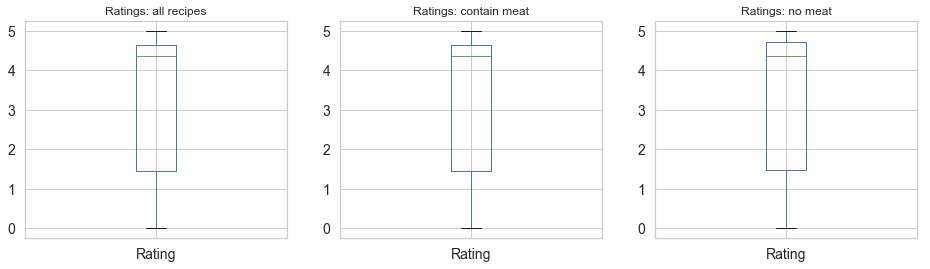

In [28]:
plt.figure(figsize=(16,4))

plt.subplot(131)
df_clean.describe().iloc[2:].boxplot(column='Rating')
plt.title('Ratings: all recipes')

plt.subplot(132)
df_meat.describe().iloc[2:].boxplot(column='Rating')
plt.title('Ratings: contain meat')

plt.subplot(133)
df_no_meat.describe().iloc[2:].boxplot(column='Rating')
plt.title('Ratings: no meat')

We can observe that whatever the recipe composition (meat ingrdients or not) the ratings have a similar distribution.

Text(0.5,1,'Carbon footprint: contain meat, CO2eq < 5kg')

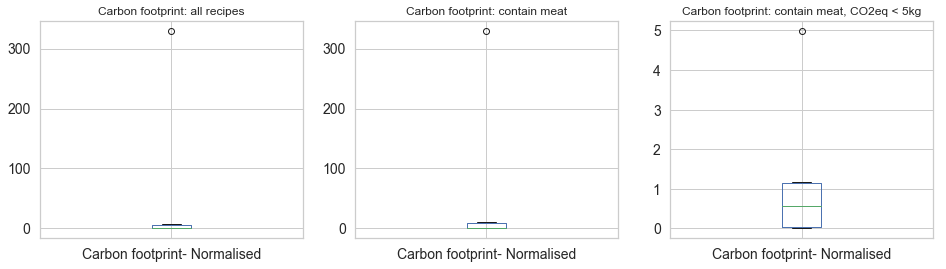

In [29]:
plt.figure(figsize=(16,4))
plt.title('Carbon footprint of recipes')

plt.subplot(131)
df_clean.describe().iloc[2:].boxplot(column='Carbon footprint- Normalised')
plt.title('Carbon footprint: all recipes')

plt.subplot(132)
df_meat.describe().iloc[2:].boxplot(column='Carbon footprint- Normalised')
plt.title('Carbon footprint: contain meat')

plt.subplot(133)
df_meat[df_meat['Carbon footprint- Normalised'] < 5].describe().iloc[2:].boxplot(column='Carbon footprint- Normalised')
plt.title('Carbon footprint: contain meat, CO2eq < 5kg')

We can clearly see in the boxplots above that there are some outliers with carbon footprints orders of magnitude above other values, which might result from data extraction errors such as a meat recipe for a crowd labelled as one serving.

### Correlations

In [30]:
print('Spearman Correlation for all recipes:')
print(df_clean.corr(method='spearman'))
print('Spearman Correlation for meat recipes:')
print(df_meat.corr(method='spearman'))

Spearman Correlation for all recipes:
                              Has meat  Carbon footprint- Normalised    Rating
Has meat                      1.000000                      0.716639 -0.040719
Carbon footprint- Normalised  0.716639                      1.000000 -0.007793
Rating                       -0.040719                     -0.007793  1.000000
Spearman Correlation for meat recipes:
                              Has meat  Carbon footprint- Normalised    Rating
Has meat                           NaN                           NaN       NaN
Carbon footprint- Normalised       NaN                      1.000000  0.075395
Rating                             NaN                      0.075395  1.000000


The figures above show that there is no appearent correlation between carbon footpring and ratings. 

###  First Visual Exploration

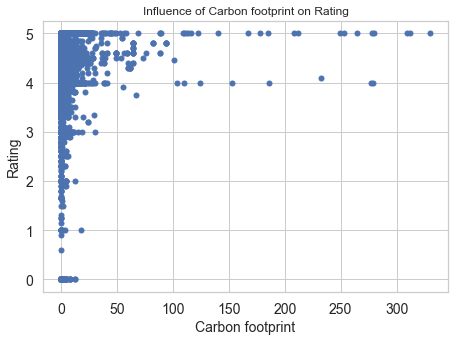

In [31]:
# Scatterplot:
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.scatter(df_clean['Carbon footprint- Normalised'], df_clean['Rating'], s=25) 
plt.title('Influence of Carbon footprint on Rating')
plt.xlabel('Carbon footprint')
plt.ylabel('Rating')
plt.show()

We can see that many of the high-impact recipes have a high rating. While the low-impact recipes span all ratings, they are more concentrated in the upper numbers.

## Designing a Green Tag for each recipe based on its carbon footprint

Inspired by the tags we find on electronic devices. The recipes without any ingredient figuring in the list of meat types gets tag AA. The rest of the cathegories are established by grouping the recipes into 5 quantiles based on their carbon footprint. With the tag one has access to the information on how bad or how good one is doing compared to the rest of the recipes. We think that this gives a more intuitive estimate for the cook than some number. However, we would like to strike, that between two subsequent labels we observe a difference or around one order of magnitude. This means that for the same carbon footprint of a meal from category E you can cook 100 meals from category C.

In [32]:
# Define colors for each Tag:
color_AA = 'green'
color_A = 'limegreen'
color_B = 'gold'
color_C = 'orange'
color_D = 'red'
color_E = 'darkred'
color_list = [color_AA, color_A, color_B, color_C, color_D, color_E]
tig_list = ['AA', 'A', 'B', 'C', 'D', 'E']

In [33]:
# All Recipes without meat or cheese or eggs receive a rating AA
#df_no_meat['Label']='AA'
A = df_meat['Carbon footprint- Normalised'].quantile(q=0.2)
B = df_meat['Carbon footprint- Normalised'].quantile(q=0.4)
C = df_meat['Carbon footprint- Normalised'].quantile(q=0.6)
D = df_meat['Carbon footprint- Normalised'].quantile(q=0.8)
E = df_meat['Carbon footprint- Normalised'].max()

print("The Carbon footprint is labelled as follows:")
print("A = 0 - ",A)
print("B = ", A, " - ",B)
print("C = ", B, " - ",C)
print("D = ", C, " - ",D)
print("E = ", D, " - ",E)

The Carbon footprint is labelled as follows:
A = 0 -  0.0144
B =  0.0144  -  0.0576
C =  0.0576  -  0.57407722401769
D =  0.57407722401769  -  2.6077097505668934
E =  2.6077097505668934  -  329.725


In [34]:
df_no_meat = df_no_meat.assign(Label = 'AA')
df_no_meat = df_no_meat.sort_values(by=['Rating'],ascending=False)
df_meat['Label'] = pd.qcut(df_meat['Carbon footprint- Normalised'], 5, labels=['A','B','C','D','E'],precision=1000)
df_meat = df_meat.sort_values(by=['Label','Rating'],ascending=[True,False])
df_clean = pd.concat([df_no_meat,df_meat])

## Correlations between appreciation and Environmental Impact of a Recipe
As we did not observe a clear correlation the first analysis we explore other means of retrieving information from our dataset.

### Visual Exploration
First we make a hexabin plot for the number of recipes as a function of rating and carbon footprint. We use only recipes with carbon footprint not equal to zero. This gives us the possibility of a log plot, which corresponds also to the logarithmic behaviour of the Green Labels. We observe that there is some pattern in which the recipes are grouped. For our work this plot is very promising, as it shows, that there are many alternative recipes with the same rating or higher for recipes with a high carbon footprint.

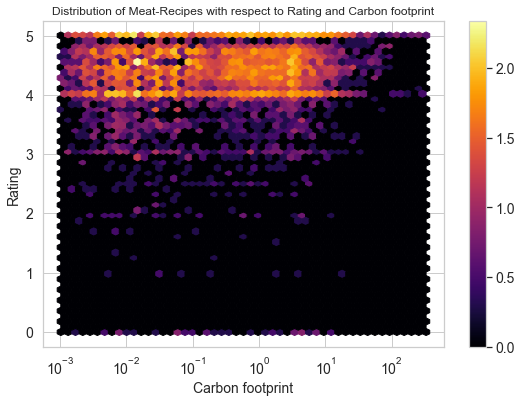

In [35]:
## Hexabinplot of data containing meat, need log plot for x-axis->no zero values
plt.figure(figsize=(9,6))
plt.set_cmap('inferno')
plt.hexbin(df_meat['Carbon footprint- Normalised'], df_meat['Rating'], gridsize=50, bins='log', xscale='log') 
plt.title('Distribution of Meat-Recipes with respect to Rating and Carbon footprint')
plt.xlabel('Carbon footprint')
plt.ylabel('Rating')
plt.colorbar()
#plt.savefig('hexabin.eps')
plt.show()

Now we look at this histogram of recipes without any ingredient in the high carbon footprint list and the recipes in category A - E. We can see that a higher percentage of recipes with no meat receive an excellent rating. Good News for the planet!!

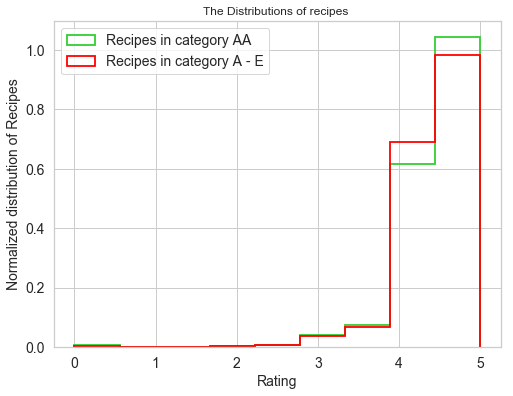

In [133]:
plt.figure(figsize=(8,6))
plt.hist(df_no_meat['Rating'], bins=np.linspace(0,5,10), histtype='step', density=True,\
         color='limegreen', linewidth=1.8, label='Recipes in category AA') 
plt.hist(df_meat['Rating'], bins=np.linspace(0,5,10), histtype='step', density=True, \
         color='red',linewidth=1.8, label='Recipes in category A - E')
plt.xlabel('Rating')
plt.ylabel('Normalized distribution of Recipes')
plt.title('The Distributions of recipes ')
plt.legend(loc=2)
#plt.savefig('DistRec.eps')
plt.show()

### Study of Excellent Recipes

The goal is to cook meals that have only little environmental impact, however the meals should be tasty! This is why we seperately analyse the properties of excellent recipes that we identify with a rating between 4.8 - 5.0. We observe, that both groups AA and E show the highest percentage of excellent recipes.

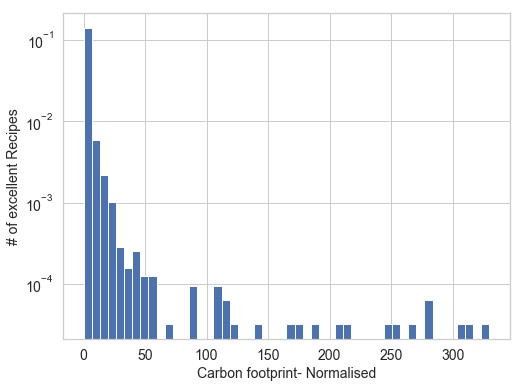

In [37]:
#Show only excellent recipes 4.8-5
df_excellent = df_clean[df_clean['Rating']>4.8]
plt.figure(figsize=(8,6))
plt.hist(df_excellent['Carbon footprint- Normalised'], bins=50, log=True, density=True)
plt.xlabel('Carbon footprint- Normalised')
plt.ylabel('# of excellent Recipes')
#plt.title('Distribution of excellent recipes with respect to their Carbon Footprint')
plt.savefig('hist_excellent.eps')
plt.show()

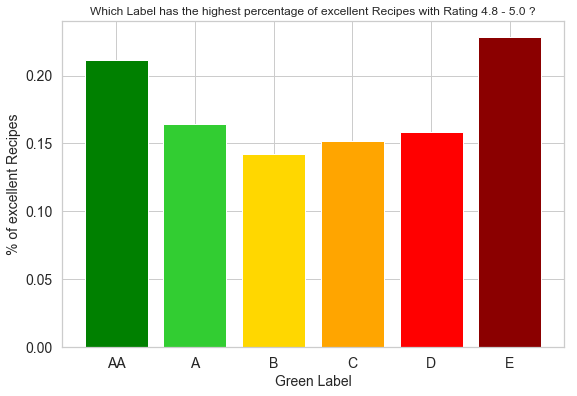

In [38]:
# Group by label and normalize with respect to number of recipes in each group.
h = df_excellent[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='# excellent recipes') \
                         .reindex([1,0,2,3,4,5])
h1 = df_clean[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='#recipes') \
                         .reindex([1,0,2,3,4,5])
df_ex = h.merge(h1)
df_ex['% of excellent recipes'] = df_ex['# excellent recipes']/df_ex['#recipes']

# plot
plt.figure(figsize=(9,6))
plt.bar(df_ex['Label'], df_ex['% of excellent recipes'], \
        color=[color_AA,color_A,color_B,color_C,color_D,color_E], \
        tick_label=tig_list)
plt.xlabel('Green Label')
plt.ylabel('% of excellent Recipes')
plt.title('Which Label has the highest percentage of excellent Recipes with Rating 4.8 - 5.0 ?')
#plt.savefig('excellent.eps')
plt.show()

### Study of Terrible Recipes
For completeness and our curiosity we do the same thing for bad recipes, with rating lower than 2.9. There are some differences between the different categories, but they are too low to be significant.

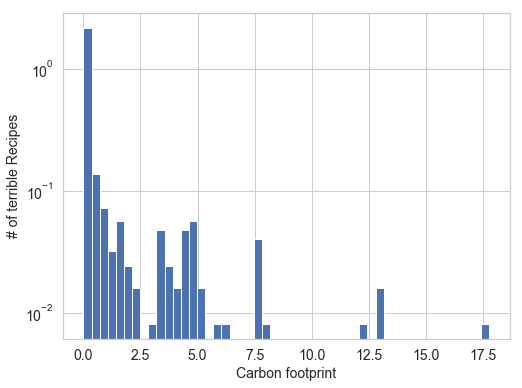

In [39]:
#Show only terrible recipes < 3.0
df_terrible = df_clean[df_clean['Rating']<3.0]
plt.figure(figsize=(8,6))
plt.hist(df_terrible['Carbon footprint- Normalised'], bins=50, log=True, density=True)
plt.xlabel('Carbon footprint')
plt.ylabel('# of terrible Recipes')
#plt.title('Distribution of excellent recipes with respect to their Carbon Footprint')
#plt.savefig('hist_excellent.eps')
plt.show()

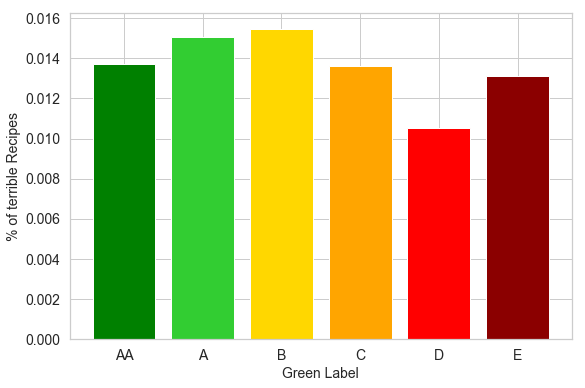

In [40]:
t = df_terrible[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='# excellent recipes') \
                         .reindex([1,0,2,3,4,5])
t1 = df_clean[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='#recipes') \
                         .reindex([1,0,2,3,4,5])
df_ter = t.merge(t1)
df_ter['% of excellent recipes'] = df_ter['# excellent recipes']/df_ter['#recipes']

#plot:

plt.figure(figsize=(9,6))
plt.bar(df_ter['Label'], df_ter['% of excellent recipes'], \
        color=[color_AA,color_A,color_B,color_C,color_D,color_E], \
        tick_label=tig_list)
plt.xlabel('Green Label')
plt.ylabel('% of terrible Recipes')
#plt.title('Which Label has the highest percentage of excellent Recipes with Rating 4.8 - 5.0 ?')
plt.savefig('terrible.eps')
plt.show()

In the graphs above, we can see that the "terrible" recipes also have a worse labels than the excellent recipes. We can only recommend our readers to cook tasty recipes that are also good for the environment! 

### Brief look on the different recipe pages

If we want people to change habits and look into recipes with a lower carbon footprint, we need recipes that are readily available on their favourite websites to support their cooking. 
We observe, that all of the recipe pages feature a high amount of low carbon footprint recipes, and offer therefore alternatives.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff52dacf390>,
      dtype=object)

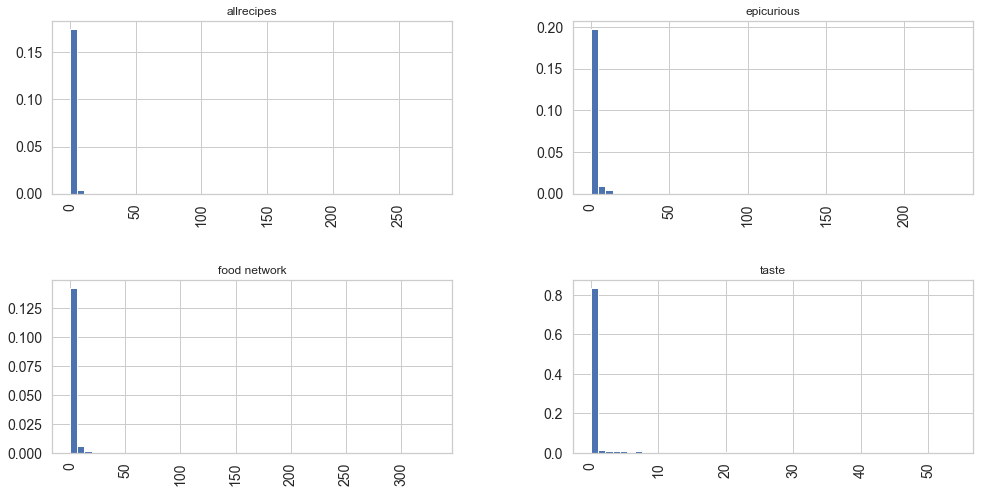

In [41]:
df_clean['Carbon footprint- Normalised'].hist(by=df_clean['Website'],bins=50,figsize=(16,8),\
                                 xlabelsize=FontSize,ylabelsize=FontSize, density=True)

### Data exploration and basic analysis


We now want to explore in more detail the composition of the meat recipes and how they might relate to ratings. 

In [111]:
#sort dataframe
df_sorted_meat = df_meat.sort_values(['Carbon footprint- Normalised'], ascending=False).reset_index(drop=True)

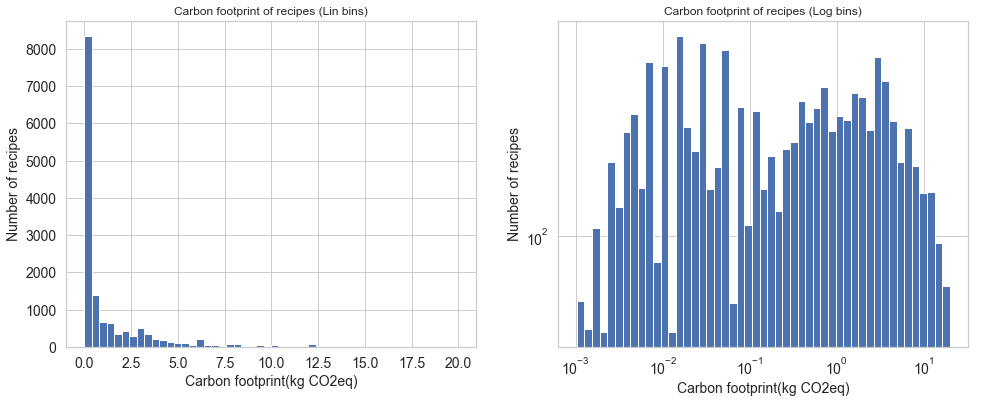

<Figure size 432x288 with 0 Axes>

In [112]:
# We plot the carbon footprints to see how they compare
plt.figure(figsize=(25,6))

data = df_sorted_meat[df_sorted_meat['Carbon footprint- Normalised']<20]['Carbon footprint- Normalised']
logbins=np.logspace(np.log10(np.min(data)),np.log10(np.max(data)),50)
bin_width=logbins[1::]-logbins[:-1]
log_width=(np.log10(logbins[1::])-np.log10(logbins[:-1]))[0]

plt.subplot(131)
plt.hist(data,bins=50) 
plt.title('Carbon footprint of recipes (Lin bins)')
plt.xlabel('Carbon footprint(kg CO2eq)')
plt.ylabel('Number of recipes')

plt.subplot(132)
plt.hist(data,bins=logbins) #bar plot on log-log scale with constant log bins
plt.xscale('log')
plt.yscale('log')
plt.title('Carbon footprint of recipes (Log bins)')
plt.xlabel('Carbon footprint(kg CO2eq)')
plt.ylabel('Number of recipes')

plt.show()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)

We can see the biggest impact recipes have a carbon footprint orders of magnitude above the other recipes' footprint; the tail of the distribution flattens out in the end. As we are aware of some quantity extraction errors in our methodology, it makes sense to get rid of there datapoints. We will only keep recipes with a carbon footprint lower than 10kg CO2 equivalent in further analysis.

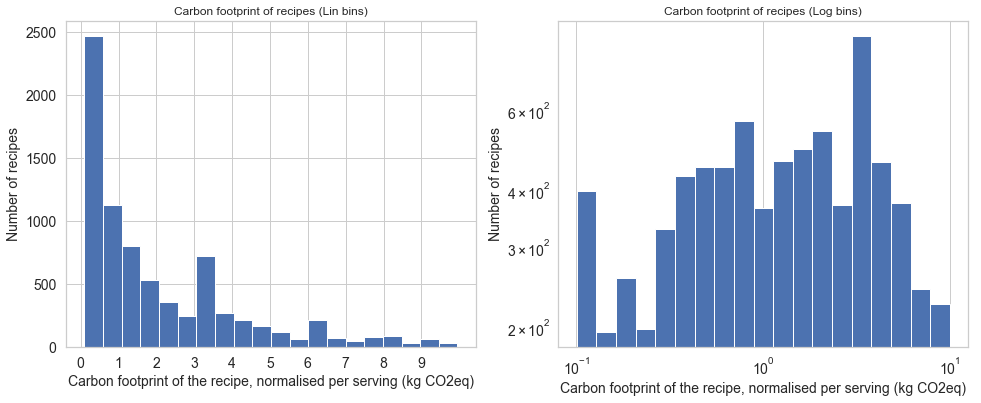

<Figure size 432x288 with 0 Axes>

In [128]:
#remove recipes with a zero score and those with an anormally high footprint
df_sorted_meat_cropped = df_sorted_meat[(df_sorted_meat['Carbon footprint- Normalised'] >= 0.1) &\
                                        (df_sorted_meat['Carbon footprint- Normalised'] <= 10)]

# We plot the carbon footprints to see how they compare
plt.figure(figsize=(25,6))
dmin = np.min(data)
dmax = np.max(data)
ticks = np.arange(0,10,1)

data = df_sorted_meat_cropped['Carbon footprint- Normalised']
logbins=np.logspace(np.log10(dmin),np.log10(dmax),20)

plt.subplot(131)
plt.hist(data,bins=20) 
plt.title('Carbon footprint of recipes (Lin bins)')
plt.xlabel('Carbon footprint of the recipe, normalised per serving (kg CO2eq)')
plt.ylabel('Number of recipes')
plt.xticks(ticks)

plt.subplot(132)
plt.hist(data,bins=logbins) #bar plot on log-log scale with constant log bins
plt.xscale('log')
plt.yscale('log')
plt.title('Carbon footprint of recipes (Log bins)')
plt.xlabel('Carbon footprint of the recipe, normalised per serving (kg CO2eq)')
plt.ylabel('Number of recipes')

plt.show()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)

### Assumptions
We assume we can assign a "median" carbon footprint value to all recipes in which we detected meat ingredients but couldn't extract a meat quantity. 

In [130]:
meat_products = ['lamb', 'beef', 'cheese', 'pork', 'turkey', 'chicken', 'tuna', 'egg']

def normalize_servings(amount, servs):
    #input is ingredient quantity in kg
    #interpret servings as a total quantity using the check_quantity function
    tot_servs = servs.str.extract(r'(\d+)')#find value
    tot_servs=tot_servs.fillna(value='4') #replace missing values with 4
    tot_servs=tot_servs.astype(int) #convert to int
    tot_servs=tot_servs.replace(0, 4) #replace missing values with 4
    amount_norm=amount/tot_servs[0]
    return amount_norm

def meat_quantities(recipe_data):
    '''
    Input: recipe dataframe row. Output: meat quantity dataframe.
    Reads and converts the list of meat ingredients and quantities from string to values then creates
    and returns a DataFrame with all meat quantitities per meat type.
    '''
    columns = literal_eval(recipe_data['Meat types'])
    rows = literal_eval(recipe_data['Meat quantity (kg)'])    
    df = pd.DataFrame(np.array(rows).reshape(1,len(rows)), columns=columns)
    
    
    for meat in meat_products:
        if meat in columns:
            df[meat] = pd.DataFrame(df[meat]).sum(axis=1)
            
    df = df.T.drop_duplicates().T.reindex(labels=meat_products, axis='columns')
    df['Servings'] = recipe_data['Servings']
    df['Rating'] = recipe_data['Rating']
    return df

def meat_quantities_df(dataframe, assign_median=False, normalise=True):
    
    meat_qty_df = pd.DataFrame(columns=meat_products)
    c=0
        
    for i in np.arange(len(dataframe)):
        try:
            new_row = meat_quantities(dataframe.iloc[i])

            for meat in meat_products:
                if ((assign_median == True) & (new_row[meat].iloc[0] != np.nan) & (new_row[meat].iloc[0] <= 0.01)):
                    new_row[meat] = meat_medians[meat]
                    
            meat_qty_df = pd.concat([meat_qty_df,new_row], sort=True)
            
        except:
            c = c+1
            pass
    
    if normalise==True:
        for meat in meat_products:
            meat_qty_df[meat] = normalize_servings(meat_qty_df[meat], meat_qty_df['Servings'])

    #print('exception count: '+str(c))
    
    #if (assign_median == True):
     #   meat_qty_df = meat_qty_df.replace(np.nan, 0)
    
    return meat_qty_df

In [159]:
#We extract the meat quantities for all recipes having quantities extracted, removing very low values
meat_qty_df = meat_quantities_df(df_sorted_meat[df_sorted_meat['Carbon footprint- Normalised'] >= 0.01])

#Now we can extract the median and mean amounts of meat ingredients in recipes
meat_medians = meat_qty_df.median(axis='rows', skipna=True)
meat_means = meat_qty_df.mean(axis='rows', skipna=True)

#Assign this median value to all zeroes in meat quantities
meat_qty_all = meat_quantities_df(df_sorted_meat, assign_median=True)

print(meat_medians)
print(meat_means)

Rating     4.500000
beef       0.113379
cheese     0.025515
chicken    0.083277
egg        0.006000
lamb       0.198413
pork       0.144570
tuna       0.056699
turkey     0.113379
dtype: float64
Rating     4.412845
beef       0.259093
cheese     0.068573
chicken    0.219421
egg        0.010165
lamb       0.361099
pork       0.254973
tuna       0.098474
turkey     0.917154
dtype: float64


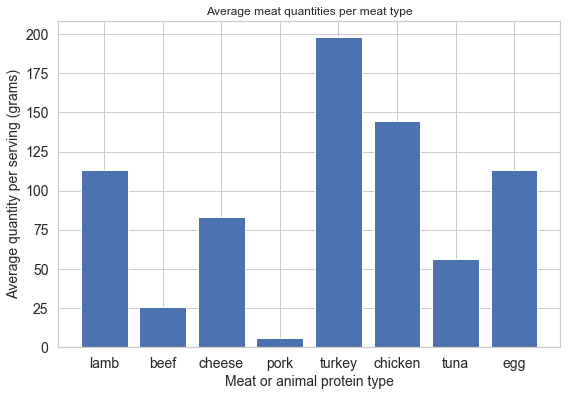

In [147]:
plt.figure(figsize=(9,6))
plt.bar(meat_products, meat_medians[1:]*1000)
plt.xlabel('Meat or animal protein type')
plt.ylabel('Median quantity per serving (grams)')
plt.title('Median meat quantities per meat type')
plt.show()

Now that we have meat values per recipe and the median values we can analyse their carbon implications.

In [155]:
#carbon footprint graph

#Load data from xls file
carbon_footprint_list = pd.read_excel('data/carbon_footprint_protein.xls', sheet_name='meat_dairy_eggs', index_col=0)
carbon_footprint_list = carbon_footprint_list[['Food','CO2 Kilos Equivalent']]
carbon_footprint_list['Food']=['lamb','beef','cheese','pork','turkey','chicken','tuna','egg']
carbon_footprint_list

meat_medians

,Food,CO2 Kilos Equivalent
Rank,,
1,lamb,39.2
2,beef,27.0
3,cheese,13.5
4,pork,12.1
5,turkey,10.9
6,chicken,6.9
7,tuna,6.1
8,egg,4.8


In [178]:
carbon_footprint_list[carbon_footprint_list['Food'] == 'beef']['CO2 Kilos Equivalent']

Rank
2    27.0
Name: CO2 Kilos Equivalent, dtype: float64

In [174]:
meat_qty_all.head(5)


,Rating,Servings,beef,cheese,chicken,egg,lamb,pork,tuna,turkey
0,5.0,1 liter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.25
0,5.0,4 to 5 servings,11.564626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5.0,4 servings,11.451247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5.0,4 servings,10.354875,NaN,NaN,0.0015,NaN,NaN,NaN,NaN
0,4.0,4 large servings,10.317460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
meat_qty_all.iloc[1]['beef']*carbon_footprint_list[carbon_footprint_list['Food'] == 'beef']['CO2 Kilos Equivalent'].iloc[0]

312.2448979591837

In [185]:
len(meat_qty_all)

14520

In [218]:
def carbon_footprints(meat_qty):
    
    cf = pd.DataFrame(columns=meat_products)
    
    for i in np.arange(len(meat_qty)):
        try:
            for meat in meat_products:
                print(type(meat_qty[meat].iloc[i]))
                print(meat_qty[meat].iloc[i] == np.nan)
                if (meat_qty[meat].iloc[i] != np.nan):
                    print(hello)
                    cf[meat].iloc[i] = meat_qty.iloc[i][meat]*carbon_footprint_list[carbon_footprint_list['Food'] == meat]\
                                                                                       ['CO2 Kilos Equivalent'].iloc[0]
                else:
                    cf[meat].iloc[i] = meat_qty[meat].iloc[i]
                    
        except:
            print('except')
            pass

    return cf

carbon_footprints(meat_qty_all.head(1))



<class 'numpy.float64'>
False
except


,lamb,beef,cheese,pork,turkey,chicken,tuna,egg


In [137]:
# Count number of recipes having each meat ingredient
meat_count = meat_qty_all.count(axis=0)

meat_count


Rating      14520
Servings    14470
beef         2161
cheese       4141
chicken      2452
egg          8803
lamb          157
pork          984
tuna          120
turkey        431
dtype: int64

In [ ]:
#Assign carbon footprint to each meat ingredient

In [153]:
#Analyse main impact of carbon footprint & correlation with ratings

### Clustering 

In [ ]:
#transfer corpus into vector space

#calculating distance between each title as a measure of similarity

#clustering the documents using the k-means algorithm


#using multidimensional scaling to reduce dimensionality within the corpus
